In [ ]:
#!pip install seaborn
#!pip install imblearn
#!pip install xgboost
#!pip install catboost
#!pip install lightgbm

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression,LogisticRegression,Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error,accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool, cv
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV, cross_val_score

In [5]:
df = pd.read_csv("/content/diabetes_prediction_dataset.csv")

df.head()

df.info()

df.describe().transpose()


df.shape


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


(100000, 9)

Column Names:
['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level', 'diabetes']


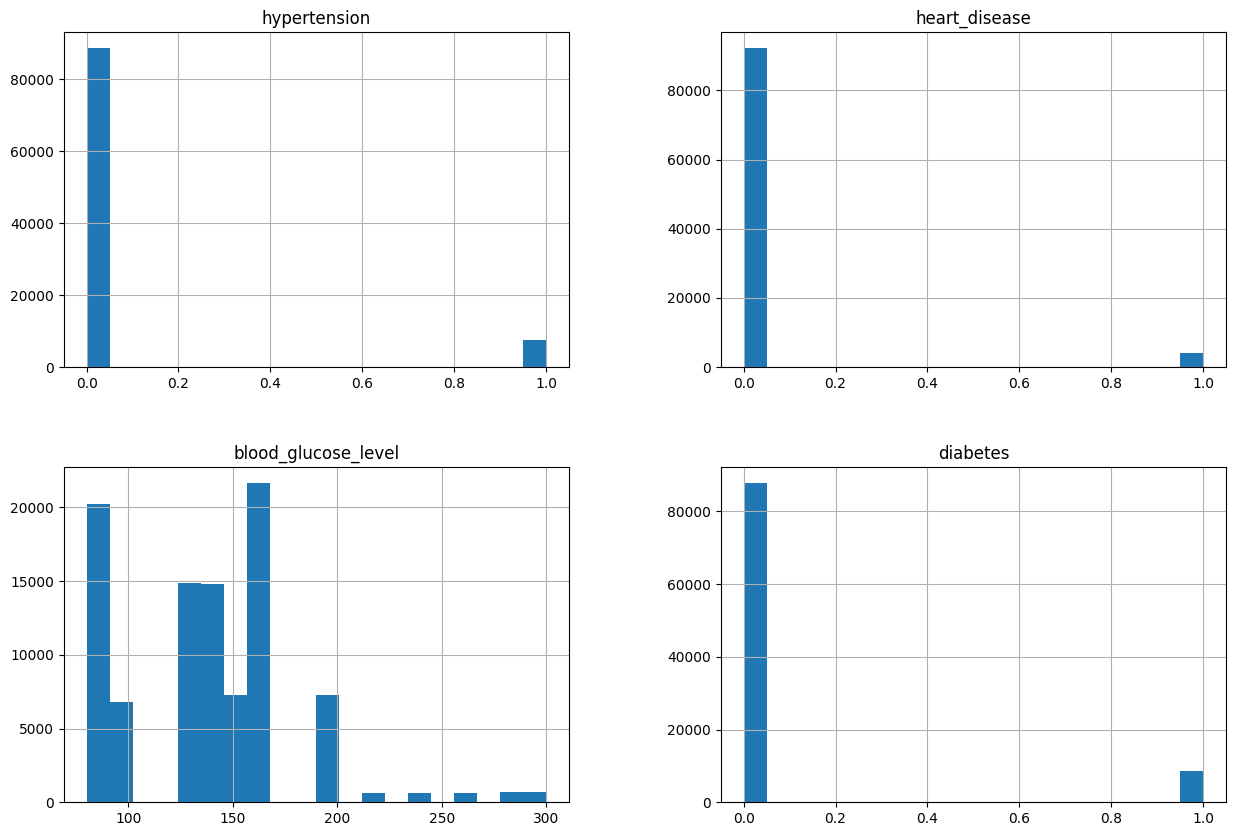

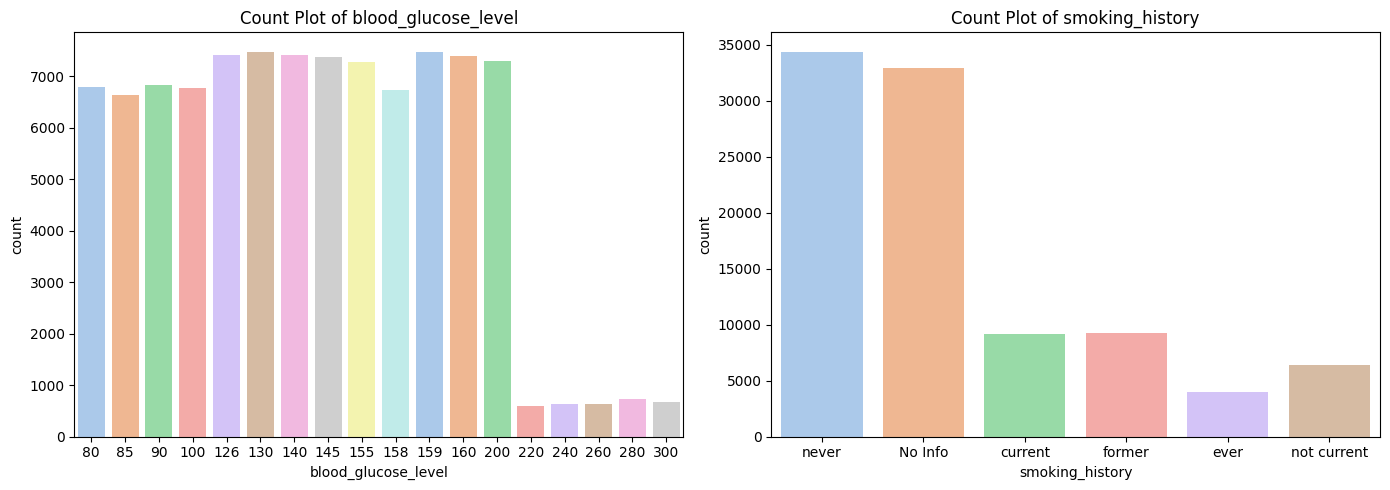

In [7]:
#Check for null values in the dataset
df.isnull().sum()

#Checking the number of unique values
df.select_dtypes(include='int64').nunique()


#check duplicate values
df.duplicated().sum()

#drop the duplicated values
df = df.drop_duplicates()

df.shape

column_names = df.columns.tolist()
print("Column Names:")
print(column_names)

numeric_columns = df.select_dtypes(include=['int64'])
numeric_columns.hist(bins=20, figsize=(15, 10))
plt.show()

# Combined side-by-side count plot for categorical variables
categorical_columns = ['blood_glucose_level','smoking_history',]
fig, axes = plt.subplots(nrows=1, ncols=len(categorical_columns), figsize=(14, 5))

for i, col in enumerate(categorical_columns):
    sns.countplot(x=col, data=df, ax=axes[i], palette='pastel')
    axes[i].set_title(f'Count Plot of {col}')

plt.tight_layout()
plt.show()

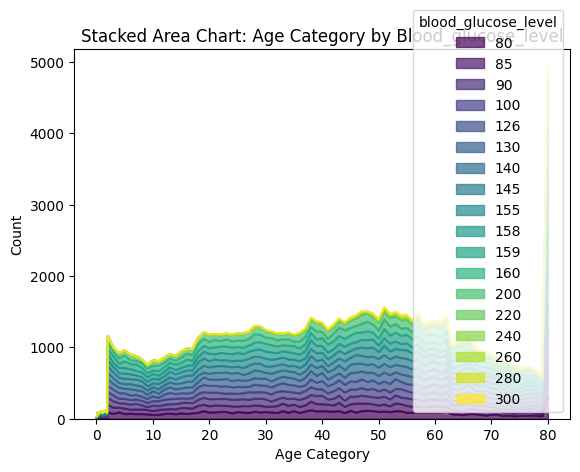

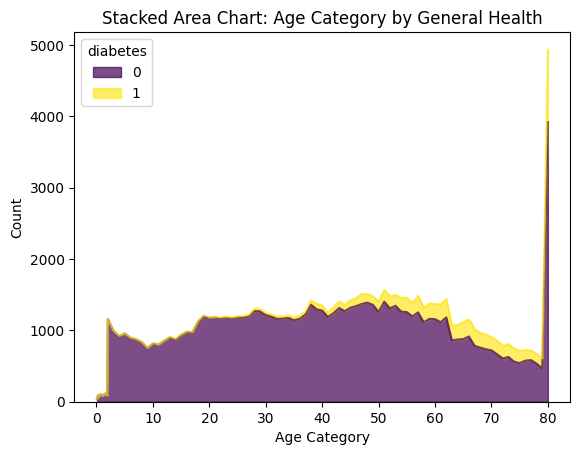

In [8]:

#Stacked Area Chart .
crosstab = pd.crosstab(df['age'],df['blood_glucose_level'])
crosstab.plot(kind='area', colormap='viridis', alpha=0.7, stacked=True)
plt.title('Stacked Area Chart: Age Category by Blood_glucose_level')
plt.xlabel('Age Category')
plt.ylabel('Count')
plt.show()

#Stacked Area Chart .
crosstab = pd.crosstab(df['age'],df['diabetes'])
crosstab.plot(kind='area', colormap='viridis', alpha=0.7, stacked=True)
plt.title('Stacked Area Chart: Age Category by General Health')
plt.xlabel('Age Category')
plt.ylabel('Count')
plt.show()


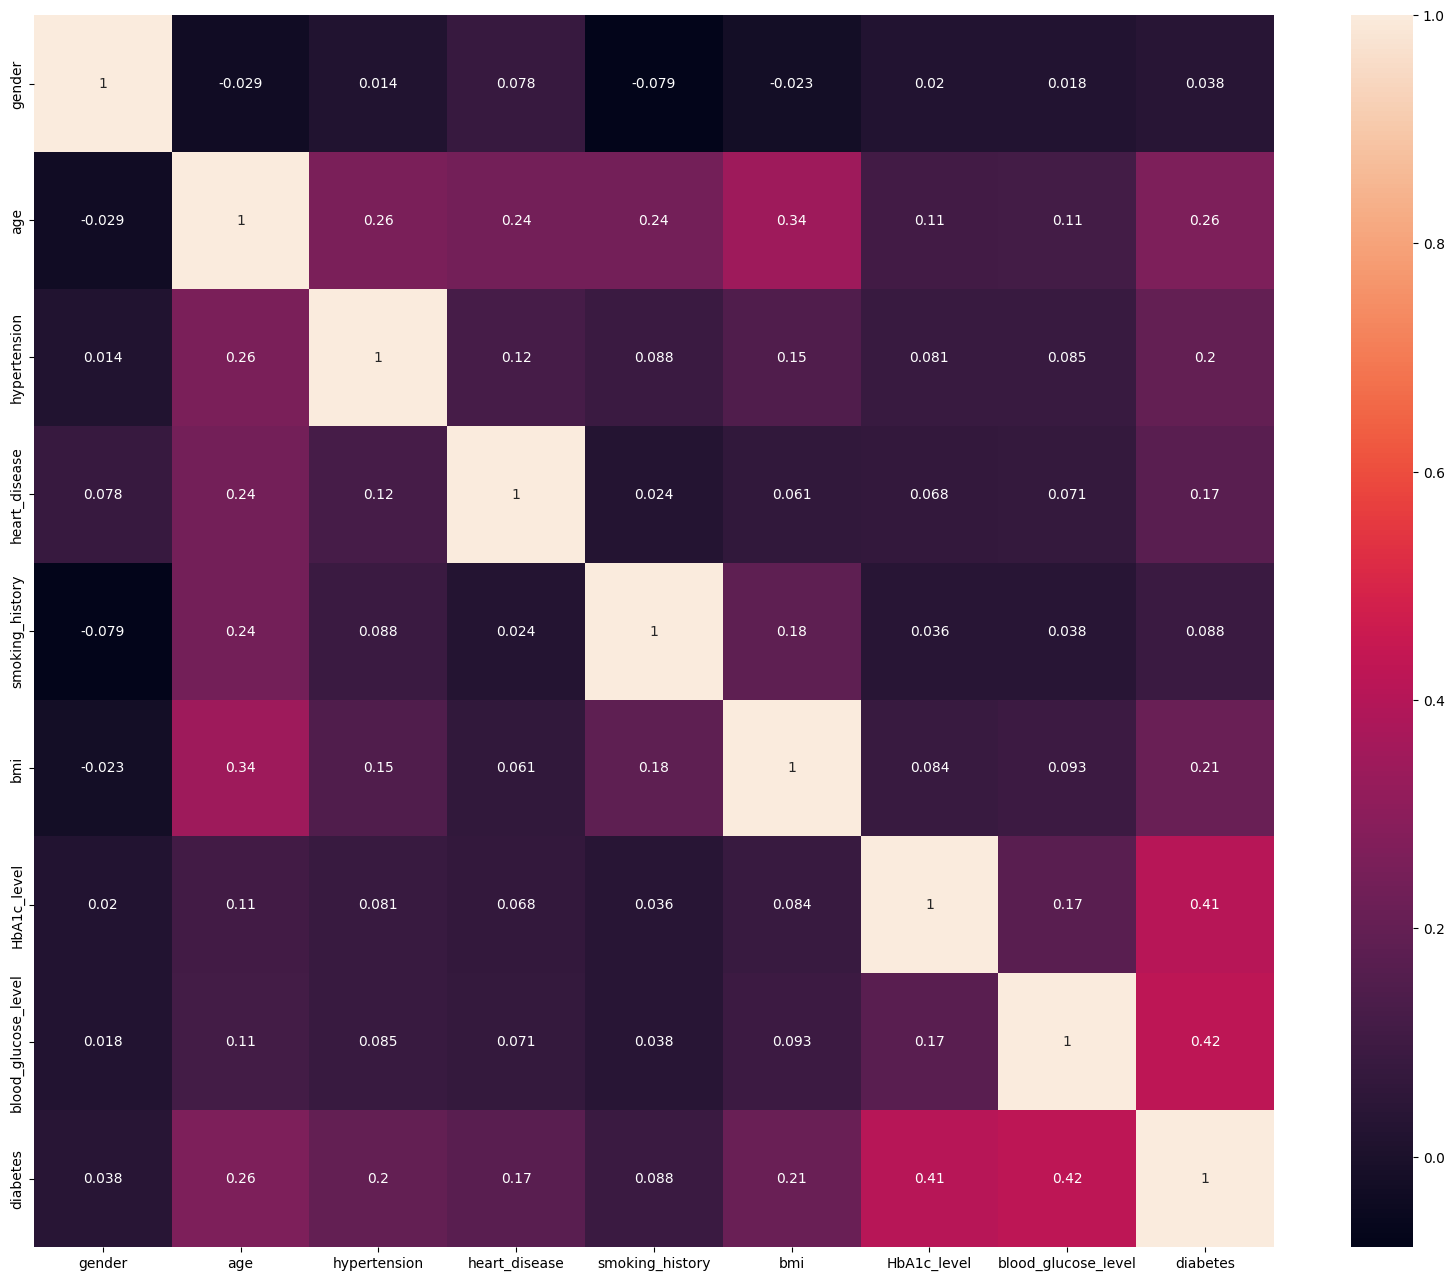

In [9]:
# Create a copy of the DataFrame to avoid modifying the original
df_encoded = df.copy()

# Create a label encoder object
label_encoder = LabelEncoder()

# Iterate through each object column and encode its values
for column in df_encoded.select_dtypes(include='object'):
    df_encoded[column] = label_encoder.fit_transform(df_encoded[column])

# Now, df_encoded contains the label-encoded categorical columns
df_encoded.head()

#Correlation Heatmap
plt.figure(figsize=(20, 16))
sns.heatmap(df_encoded.corr(), fmt='.2g', annot=True)

#CHECK THE CLASS VARIABLE
df_encoded['diabetes'].value_counts()

# Split the data into training and testing sets
X = df_encoded.drop(columns=['diabetes'])  # Features
y = df_encoded['diabetes']  # Target variable


In [10]:

smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Print the shapes of the new splits
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Define the columns to remove outliers
selected_columns = ['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Calculate the IQR for the selected columns in the training data
Q1 = X_train[selected_columns].quantile(0.25)
Q3 = X_train[selected_columns].quantile(0.75)
IQR = Q3 - Q1

# SetTING a threshold value for outlier detection (e.g., 1.5 times the IQR)
threshold = 1.5

# CreatING a mask for outliers in the selected columns
outlier_mask = (
    (X_train[selected_columns] < (Q1 - threshold * IQR)) |
    (X_train[selected_columns] > (Q3 + threshold * IQR))
).any(axis=1)

# Remove rows with outliers from X_train and y_train
X_train_clean = X_train[~outlier_mask]
y_train_clean = y_train[~outlier_mask]

# Print the number of rows removed
num_rows_removed = len(X_train) - len(X_train_clean)
print(f"Number of rows removed due to outliers: {num_rows_removed}")


X_train shape: (140262, 8)
X_test shape: (35066, 8)
y_train shape: (140262,)
y_test shape: (35066,)
Number of rows removed due to outliers: 43189


In [11]:
lr_model = LinearRegression()
lr_model.fit(X_train_clean, y_train_clean)

# Make predictions on the test set
lr_predictions = lr_model.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, lr_predictions)
mae = mean_absolute_error(y_test, lr_predictions)
print(f"Linear Regression Mean Squared Error: {mse:.2f}")
print(f"Linear Regression Mean Absolute Error: {mae:.2f}")

Linear Regression Mean Squared Error: 0.11
Linear Regression Mean Absolute Error: 0.28


In [12]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train_clean, y_train_clean)

# Make predictions on the test set
logistic_predictions = logistic_model.predict(X_test)

# Calculate AUC
logistic_auc = roc_auc_score(y_test, logistic_predictions)

# Generate ROC curve
fpr, tpr, _ = roc_curve(y_test, logistic_predictions)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, logistic_predictions)
print(f"Logistic Regression Accuracy: {accuracy:.2f}")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, logistic_predictions))



Logistic Regression Accuracy: 0.89
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     17439
           1       0.88      0.90      0.89     17627

    accuracy                           0.89     35066
   macro avg       0.89      0.89      0.89     35066
weighted avg       0.89      0.89      0.89     35066



In [13]:
# Create a pipeline with the KNN classifier
knn_pipeline = make_pipeline(KNeighborsClassifier())

# Define the parameter grid for GridSearchCV
param_grid = {
    'kneighborsclassifier__n_neighbors': [3, 5, 7],  # You can add more values to test
    'kneighborsclassifier__weights': ['uniform', 'distance'],
}

# Create the GridSearchCV object
grid_search = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='accuracy')

# Fit the model to the training data
grid_search.fit(X_train_clean, y_train_clean)

# Get the best parameters and best estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Predict on the test set using the best estimator
y_pred = best_estimator.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Model Accuracy:", accuracy)
print("Classification Report:\n", report)


Best Parameters: {'kneighborsclassifier__n_neighbors': 3, 'kneighborsclassifier__weights': 'distance'}
Model Accuracy: 0.934181258198825
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93     17439
           1       0.91      0.96      0.94     17627

    accuracy                           0.93     35066
   macro avg       0.94      0.93      0.93     35066
weighted avg       0.94      0.93      0.93     35066



In [14]:
# Best Parameters for Decision Tree Classifier
best_params = {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2}

# Create and train the Decision Tree Classifier with the specified parameters
dt_classifier = DecisionTreeClassifier(criterion=best_params['criterion'],
                                       max_depth=best_params['max_depth'],
                                       min_samples_leaf=best_params['min_samples_leaf'],
                                       min_samples_split=best_params['min_samples_split'],
                                       random_state=0)

dt_classifier.fit(X_train_clean, y_train_clean)

# Predict on the test set
y_pred_dt = dt_classifier.predict(X_test)

# Evaluate the Decision Tree model
accuracy_dt = accuracy_score(y_test, y_pred_dt)
report_dt = classification_report(y_test, y_pred_dt)

print("Decision Tree Model Accuracy:", accuracy_dt)
print("Decision Tree Classification Report:\n", report_dt)


Decision Tree Model Accuracy: 0.9709690298294644
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97     17439
           1       0.98      0.96      0.97     17627

    accuracy                           0.97     35066
   macro avg       0.97      0.97      0.97     35066
weighted avg       0.97      0.97      0.97     35066



In [15]:
# Create and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=0, max_features='sqrt', n_estimators=100, max_depth=10)
rf_classifier.fit(X_train_clean, y_train_clean)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Model Accuracy:", accuracy)
print("Classification Report:\n", report)


Model Accuracy: 0.9236582444533166
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.91      0.92     17439
           1       0.92      0.93      0.92     17627

    accuracy                           0.92     35066
   macro avg       0.92      0.92      0.92     35066
weighted avg       0.92      0.92      0.92     35066



In [16]:
# Create and train the XGBoost Classifier
xgb_classifier = XGBClassifier(random_state=42,max_features='sqrt', n_estimators=100, max_depth=10)
xgb_classifier.fit(X_train_clean, y_train_clean)

# Predict on the test set
y_pred = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("XGBoost Model Accuracy:", accuracy)
print("Classification Report:\n", report)


XGBoost Model Accuracy: 0.9750185364740774
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.98     17439
           1       0.99      0.96      0.97     17627

    accuracy                           0.98     35066
   macro avg       0.98      0.98      0.98     35066
weighted avg       0.98      0.98      0.98     35066



In [17]:
# Create the CatBoost Classifier
catboost_classifier = CatBoostClassifier(random_seed=42, logging_level='Silent', learning_rate=0.1, depth=10,subsample=0.8)

catboost_classifier.fit(X_train_clean, y_train_clean)

# Predict on the test set
y_pred = catboost_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("CatBoost Model Accuracy:", accuracy)
print("Classification Report:\n", report)

CatBoost Model Accuracy: 0.9804083727827525
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98     17439
           1       0.99      0.97      0.98     17627

    accuracy                           0.98     35066
   macro avg       0.98      0.98      0.98     35066
weighted avg       0.98      0.98      0.98     35066



In [18]:
# Create the Gradient Boosting Classifier
gb_classifier = GradientBoostingClassifier(random_state=42, verbose=0, learning_rate=0.1,subsample=0.8)

gb_classifier.fit(X_train_clean, y_train_clean)

# Predict on the test set
y_pred = gb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Gradient Boosting Model Accuracy:", accuracy)
print("Classification Report:\n", report)


Gradient Boosting Model Accuracy: 0.9658643700450579
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.98      0.97     17439
           1       0.98      0.95      0.97     17627

    accuracy                           0.97     35066
   macro avg       0.97      0.97      0.97     35066
weighted avg       0.97      0.97      0.97     35066



In [19]:
# Create the LightGBM Classifier
lgb_classifier = LGBMClassifier(random_state=42)

lgb_classifier.fit(X_train_clean, y_train_clean)

# Predict on the test set
y_pred = lgb_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("LightGBM Model Accuracy:", accuracy)
print("Classification Report:\n", report)

[LightGBM] [Info] Number of positive: 45459, number of negative: 51614
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003255 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 802
[LightGBM] [Info] Number of data points in the train set: 97073, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.468297 -> initscore=-0.126982
[LightGBM] [Info] Start training from score -0.126982
LightGBM Model Accuracy: 0.9724519477556608
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.99      0.97     17439
           1       0.99      0.95      0.97     17627

    accuracy                           0.97     35066
   macro avg       0.97      0.97      0.97     35066
weighted avg       0.97      0.97      0.97     35066



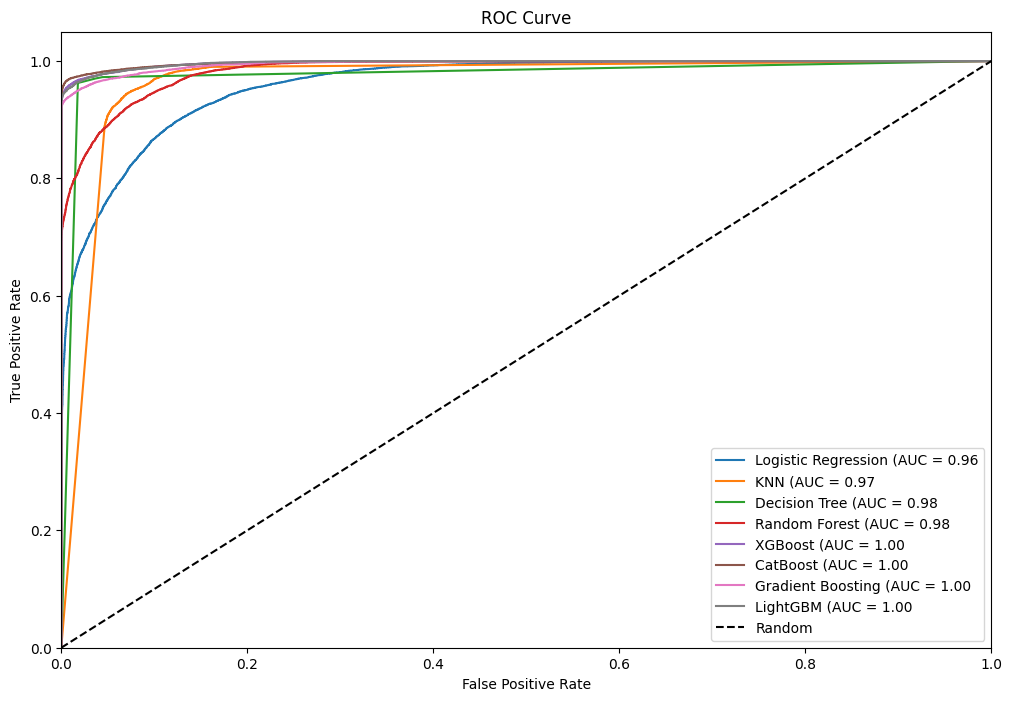

In [20]:
# Define a list of classifiers and their names excluding Linear Regression
classifiers = [logistic_model, best_estimator, dt_classifier, rf_classifier, xgb_classifier, catboost_classifier, gb_classifier, lgb_classifier]
classifier_names = ["Logistic Regression", "KNN", "Decision Tree", "Random Forest", "XGBoost", "CatBoost", "Gradient Boosting", "LightGBM"]

# Create a function to plot ROC curve and calculate AUC
def plot_roc_curve_and_auc(classifiers, classifier_names, X_test, y_test):
    plt.figure(figsize=(12, 8))
    for classifier, name in zip(classifiers, classifier_names):
        if hasattr(classifier, 'predict_proba'):  # Check if the classifier has predict_proba method
            y_pred_prob = classifier.predict_proba(X_test)[:, 1]
        else:
            try:
                y_pred_prob = classifier.decision_function(X_test)
            except AttributeError:
                raise AttributeError(f"{name} does not have predict_proba or decision_function method.")

        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        auc = roc_auc_score(y_test, y_pred_prob)
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f}")

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curves and calculate AUC for classifiers excluding Linear Regression
plot_roc_curve_and_auc(classifiers, classifier_names, X_test, y_test)



In [21]:
# Create the CatBoost Classifier
catboost_classifier = CatBoostClassifier(random_seed=42, logging_level='Silent', learning_rate=0.1, depth=10, subsample=0.8)

# Perform k-fold cross-validation
cv_scores = cross_val_score(catboost_classifier, X_train_clean, y_train_clean, cv=5, scoring='accuracy')

# Print the cross-validation scores
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())


# Select a random sample of 10 rows
random_sample = df_encoded.sample(n=25, random_state=42)

# Separate features (X) and target variable (y)
X_sample = random_sample.drop("diabetes", axis=1)
y_sample = random_sample["diabetes"]

# Load the best CatBoost model with the identified parameters
best_catboost_model = CatBoostClassifier(random_seed=42, logging_level='Silent', learning_rate=0.1, depth=10, subsample=0.8)

# Fit the model to the entire training data using the best parameters
best_catboost_model.fit(X_train_clean, y_train_clean)

# Predict on the random sample
y_pred_sample = best_catboost_model.predict(X_sample)

# Display the predictions
predictions_df = pd.DataFrame({"Actual": y_sample, "Predicted": y_pred_sample})
print(predictions_df)

Cross-Validation Scores: [0.98047901 0.98135462 0.98228174 0.98217781 0.98145668]
Mean Accuracy: 0.9815499730568176
       Actual  Predicted
2547        0          0
34774       0          0
71084       1          1
50584       0          0
80788       0          0
46976       0          0
69385       0          0
57772       0          0
87690       0          0
35032       0          0


In [22]:
# Neural Network Model with TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Assuming the data is already preprocessed and split into X_train, X_test, y_train, y_test

# Standardize the data (if not already done)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the neural network architecture
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=20, batch_size=64, validation_split=0.2, verbose=2)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Save the model
model.save('diabetes_prediction_neural_network_model.h5')


Epoch 1/20
1754/1754 - 12s - loss: 0.2574 - accuracy: 0.8829 - val_loss: 0.2156 - val_accuracy: 0.8969 - 12s/epoch - 7ms/step
Epoch 2/20
1754/1754 - 8s - loss: 0.2105 - accuracy: 0.8990 - val_loss: 0.1855 - val_accuracy: 0.9095 - 8s/epoch - 5ms/step
Epoch 3/20
1754/1754 - 8s - loss: 0.1930 - accuracy: 0.9062 - val_loss: 0.1793 - val_accuracy: 0.9116 - 8s/epoch - 4ms/step
Epoch 4/20
1754/1754 - 6s - loss: 0.1870 - accuracy: 0.9092 - val_loss: 0.1767 - val_accuracy: 0.9136 - 6s/epoch - 4ms/step
Epoch 5/20
1754/1754 - 7s - loss: 0.1844 - accuracy: 0.9109 - val_loss: 0.1749 - val_accuracy: 0.9155 - 7s/epoch - 4ms/step
Epoch 6/20
1754/1754 - 8s - loss: 0.1830 - accuracy: 0.9120 - val_loss: 0.1753 - val_accuracy: 0.9151 - 8s/epoch - 5ms/step
Epoch 7/20
1754/1754 - 8s - loss: 0.1830 - accuracy: 0.9114 - val_loss: 0.1735 - val_accuracy: 0.9157 - 8s/epoch - 5ms/step
Epoch 8/20
1754/1754 - 5s - loss: 0.1819 - accuracy: 0.9114 - val_loss: 0.1737 - val_accuracy: 0.9156 - 5s/epoch - 3ms/step
Epoch 